In [1]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [3]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", 
             "and", "any", "are", "as", "at", "be", "because", "been", "before", 
             "being", "below", "between", "both", "but", "by", "could", "did", "do", 
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", 
             "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", 
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", 
             "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", 
             "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", 
             "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", 
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", 
             "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", 
             "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", 
             "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", 
             "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

print(len(stopwords))

153


In [4]:
with open('bbc-text.csv', 'r') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    next(data)
    for row in data:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace(" ", " ")
        sentences.append(sentence)
        
print(len(sentences))

2225


In [5]:
train_size = int(training_portion*len(sentences))

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


In [6]:
set(train_labels)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen = max_length, 
                             padding = padding_type, truncating = trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

# Expected Ouput
# 449
# 120
# 200
# 120
# 192
# 120

449
120
200
120
192
120


In [7]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, maxlen = max_length,
                                  padding = padding_type, truncating = trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


In [13]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

# Expected output
# [4]
# [2]
# [1]
# (1780, 1)
# [5]
# [4]
# [3]
# (445, 1)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'relu'),
    tf.keras.layers.Dense(6, activation = 'softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

# Expected Output
# Layer (type)                 Output Shape              Param #   
# =================================================================
# embedding (Embedding)        (None, 120, 16)           16000     
# _________________________________________________________________
# global_average_pooling1d (Gl (None, 16)                0         
# _________________________________________________________________
# dense (Dense)                (None, 24)                408       
# _________________________________________________________________
# dense_1 (Dense)              (None, 6)                 150       
# =================================================================
# Total params: 16,558
# Trainable params: 16,558
# Non-trainable params: 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 150       
Total params: 160,558
Trainable params: 160,558
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs = num_epochs,
                    validation_data = (validation_padded, validation_label_seq),
                    verbose=2)

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 2s - loss: 1.7590 - accuracy: 0.4455 - val_loss: 1.7098 - val_accuracy: 0.6225
Epoch 2/30
1780/1780 - 0s - loss: 1.6364 - accuracy: 0.6107 - val_loss: 1.5439 - val_accuracy: 0.6831
Epoch 3/30
1780/1780 - 0s - loss: 1.4008 - accuracy: 0.7888 - val_loss: 1.2780 - val_accuracy: 0.7573
Epoch 4/30
1780/1780 - 0s - loss: 1.0797 - accuracy: 0.8640 - val_loss: 0.9764 - val_accuracy: 0.8697
Epoch 5/30
1780/1780 - 1s - loss: 0.7722 - accuracy: 0.9449 - val_loss: 0.7304 - val_accuracy: 0.9124
Epoch 6/30
1780/1780 - 1s - loss: 0.5305 - accuracy: 0.9674 - val_loss: 0.5469 - val_accuracy: 0.9303
Epoch 7/30
1780/1780 - 0s - loss: 0.3624 - accuracy: 0.9792 - val_loss: 0.4215 - val_accuracy: 0.9416
Epoch 8/30
1780/1780 - 1s - loss: 0.2493 - accuracy: 0.9848 - val_loss: 0.3351 - val_accuracy: 0.9506
Epoch 9/30
1780/1780 - 0s - loss: 0.1746 - accuracy: 0.9916 - val_loss: 0.2770 - val_accuracy: 0.9461
Epoch 10/30
1780/1780 - 0s - loss: 

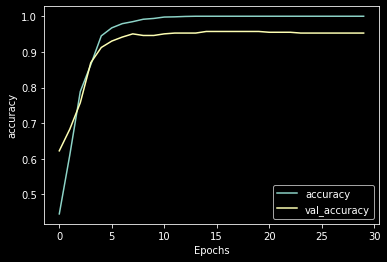

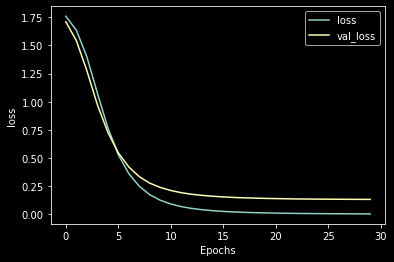

In [18]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [21]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)
